# Dataset, Dataloader, BatchNorm, Dropout, Оптимизация

Сегодня у нас довольно объемная программа, она призвана закончить большую часть про базовую функциональность Pytorch, дальше мы двинемся к сверточным сетям и будем решать более прикладные задачи

Для удобства в PyTorch предоставляется ряд утилит для загрузки датасетов, их предварительной обработки и взаимодействия с ними. Эти вспомогательные классы находятся в модуле torch.utils.data module. Здесь следует обратить внимание на:

- Dataset,
- DataLoader, отвечающий за загрузку датасета.

Для создания новых датасетов наследуется класс torch.utils.data.Dataset и переопределяется метод __len__, так, чтобы он возвращал количество образцов в датасете, а также метод __getitem__ для доступа к единичному значению по конкретному индексу. Например, так выглядит простой датасет, в котором инкапсулирован диапазон целых чисел:

## Dataset

In [ ]:
import math
import torch
import numpy as np

class RangeDataset(torch.utils.data.Dataset):
    def __init__(self, start, end, step=1):
        self.start = start
        self.end = end
        self.step = step

    def __len__(self):
        return math.ceil((self.end - self.start) / self.step)

    def __getitem__(self, index):
        value = self.start + index * self.step
        return np.array([value, value])

## Dataloader

Объект DataLoader принимает датасет и ряд опций, конфигурирующих процедуру извлечения образца. Например, можно параллельно загружать образцы, задействовав множество процессов. Для этого конструктор DataLoader принимает аргумент num_workers. Обратите внимание: DataLoader всегда возвращает батчи, размер которых задается в параметре batch_size

In [ ]:
dataset = RangeDataset(0, 14)
print(len(dataset))
dataset[0], dataset[5]

14


(array([0, 0]), array([5, 5]))

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True,
                                          num_workers=2, drop_last=True)
len(data_loader)

3

In [ ]:
for i, batch in enumerate(data_loader):
    print(i, batch)

0 tensor([[12, 12],
        [ 5,  5],
        [ 0,  0],
        [13, 13]])
1 tensor([[6, 6],
        [8, 8],
        [9, 9],
        [4, 4]])
2 tensor([[10, 10],
        [ 1,  1],
        [ 7,  7],
        [ 2,  2]])


При этом нам часто нужно делать аугментацию данных или как-то их предобрабатывать. Это можно делать внутри датасета, но частично это можно переложить и внутрь DataLoader (особенно в части обработки изображений)

In [ ]:
import numpy as np

from PIL import Image
from torchvision import transforms, datasets

In [ ]:
train_dataset = datasets.CIFAR10(root='data/', train=True, download=True)
image, label = train_dataset[0]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


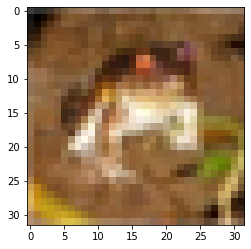

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image);

In [ ]:
img_size = 32

class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img, lbl = self._base_dataset[idx]

        if self.transform is not None:
            img = self.transform(img)
        
        img = img.view(img_size * img_size * 3)
        return img, lbl
    

trans_actions = transforms.Compose([transforms.Resize(img_size + 2),
                                    transforms.RandomCrop(img_size, padding=2), 
                                    transforms.ToTensor()])

dataset = MyOwnCifar(train_dataset, trans_actions)
train_loader = torch.utils.data.DataLoader(dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

In [ ]:
test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True,)
test_dataset = MyOwnCifar(test_dataset, 
                          transforms.Compose([transforms.ToTensor(),
                                              transforms.Resize(img_size)])
                          )

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

Files already downloaded and verified


In [ ]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 
           'frog', 'horse', 'ship', 'truck']

torch.Size([128, 3072])
label is deer


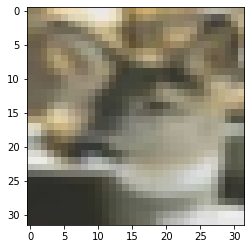

In [ ]:
for batch, label in train_loader:
    print(batch.shape)
    plt.imshow(batch[0].view(3, img_size, img_size).permute(1, 2, 0))
    print('label is', classes[label[0]])
    break

torch.Size([8, 3072])
label is cat


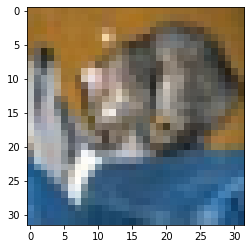

In [ ]:
for batch, label in test_loader:
    print(batch.shape)
    plt.imshow(batch[0].view(3, img_size, img_size).permute(1, 2, 0))
    print('label is', classes[label[0]])
    break

## Dropout - исключение заданного числа нейронов


Метод регуляризации искусственных нейронных сетей, предназначен для уменьшения переобучения сети за счет предотвращения сложных адаптаций отдельных нейронов на тренировочных данных во время обучения.

Характеризует исключение определённого процента (например 50%) случайных нейронов на разных итерациях во время обучения нейронной сети. В результате  обучение происходит более общее, нет надежды на определенные нейроны. Такой приём значительно увеличивает скорость обучения, качество обучения на тренировочных данных, а также повышает качество предсказаний модели на новых тестовых данных.

На моменте предсказания все нейроны включаются обратно, dropout не используется.

<img src="https://drive.google.com/uc?export=view&id=1UP-yYkA4UEfZmdFUZG-3ccftXPQcfno1">



## BatchNorm


Batch Normalization (Пакетная нормализация) — метод, который позволяет повысить производительность и стабилизировать работу искусственных нейронных сетей. Суть данного метода заключается в том, что некоторым слоям нейронной сети на вход подаются данные, предварительно обработанные и имеющие нулевое мат. ожидание и единичную дисперсию.

Batch norm дает следующие эффекты:

- ускорение сходимости модели;
- бОльшая независимость обучения каждого слоя нейронов;
- в некоторой степени предотвращает эффект переобучения;
- меньшая чувствительность к начальной инициализации весовых коэффициентов.


<img src='https://drive.google.com/uc?export=view&id=1y0ye2bQTB2cwgP4cgxVQ50Fhi8FvIZeH'>

Получается, что нейронам в одной сети приходится адаптироваться к разным картинкам на разных итерациях, потому что разные статистические показатели распределений приходят на вход, из-за чего снижается скорость сходимости, чтобы это было легче для сети, можно выполнять нормализацию батча.

Получается, что нужно нормировать статистические показатели. 
<img src="https://drive.google.com/uc?export=view&id=1kd0XCd5FSPoVR1tlD3HfA2Nc5mwdWtj1" width=400>


<img src='https://drive.google.com/uc?export=view&id=11YY3T8a31W583tJHxz-Sq7Q7A3Z02a47'>


<h2>$z^i_k = \frac{v^i_k + \mu_v}{\sqrt{ \sigma^2_v+ \epsilon}}$</h2><br>
$y_i^k = \gamma z_i^k + \beta$, где $\gamma$ и $\beta$ - это настраиваемые параметры, которые нужны для дополнительного масштабирования и смещения.








In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc2 = Perceptron(hidden_dim, 10, "relu")
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp(x)
        x = self.bn(x)
        x = self.fc2(x)
        return x

In [ ]:
net = FeedForward(3*32*32, 200)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(test_loader):
            
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_running_right += (data[1] == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
            net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/391]. Loss: 0.019. Acc: 0.078. Test acc: 0.106
Epoch [1/10]. Step [151/391]. Loss: 0.016. Acc: 0.256. Test acc: 0.336
Epoch [1/10]. Step [301/391]. Loss: 0.015. Acc: 0.306. Test acc: 0.339
Epoch [2/10]. Step [1/391]. Loss: 0.015. Acc: 0.375. Test acc: 0.376
Epoch [2/10]. Step [151/391]. Loss: 0.015. Acc: 0.333. Test acc: 0.368
Epoch [2/10]. Step [301/391]. Loss: 0.015. Acc: 0.343. Test acc: 0.379
Epoch [3/10]. Step [1/391]. Loss: 0.014. Acc: 0.320. Test acc: 0.375
Epoch [3/10]. Step [151/391]. Loss: 0.015. Acc: 0.357. Test acc: 0.384
Epoch [3/10]. Step [301/391]. Loss: 0.015. Acc: 0.350. Test acc: 0.400
Epoch [4/10]. Step [1/391]. Loss: 0.015. Acc: 0.312. Test acc: 0.396
Epoch [4/10]. Step [151/391]. Loss: 0.014. Acc: 0.357. Test acc: 0.390
Epoch [4/10]. Step [301/391]. Loss: 0.014. Acc: 0.362. Test acc: 0.387
Epoch [5/10]. Step [1/391]. Loss: 0.015. Acc: 0.336. Test acc: 0.409
Epoch [5/10]. Step [151/391]. Loss: 0.014. Acc: 0.364. Test acc: 0.400
Epoch [5/10]. St

## Оптимизаторы

Как конкретно мы собираемся обновлять параметры? Это про улучшенные методы градиентного спуска, которые есть в pytorch.
Все оптимизаторы можно найти в разделе [torch.optim](https://pytorch.org/docs/stable/optim.html)


### SGD  

В самом простом варианте , мы вычисляем наш градиент и умножаем на learningrate.
$$w = w - learning\_rate * gradient$$

Но оказывается что это не так уж и эффективно. На гифке ниже видны разные подходы оптимизаторов. Они из одной точки по-разному добираются до цели. Можно увидеть что в отличие от нашего простого метода(SGD) другие оптимизаторы выполняют свою работу намного быстрее. Это происходит в основном из-за неконстантного шага обучения:

<img src='https://i.stack.imgur.com/8rpzr.gif'>

Давайте подробнее посмотрим на эти оптимизаторы и как ими пользоваться в pytorch:

Как реализовано в pytorch:

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

### Momentum (импульс)



[статья](https://arxiv.org/abs/1810.13395?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+arxiv%252FQSXk+%2528ExcitingAds%2521+cs+updates+on+arXiv.org%2529)  
[pytorch doc](https://pytorch.org/docs/master/generated/torch.optim.SGD.html?highlight=sgd#torch.optim.SGD)

<img src='https://drive.google.com/uc?export=view&id=1JMoY1y1oZUtiicvCuhxhliiLBLoNl7bA' width=600>


$$velocity = momentum * velocity - \eta*gradient\\w = w + velocity$$

Как это математически объясняется: мы накапливаем некоторую скорость velocity, которая скорость вектора. Наш learningrate, который мы применяли к веса, теперь применяется к скорости. Т.е. по направлению градиента мы увеличиваем не просто веса, а скорость изменения весов. И есть такой момент затухания momentum, для того что бы было каке-то трение в системе, иначе все это улетит очень при очень далеко. И мы обычно берем momentum от 0.9-0.99. 
И таким образом мы берем старое значение скорости, его немного уменьшаем и добавляем к нему направление градиента. 



<img src='https://drive.google.com/uc?export=view&id=1h0u3hNo2cjDRoq0FVdXIScgRo6Iq687y' width=400>

Засчет добавления импульса получается сглаживание оптимизации.

|$t_1$|$t_2$|..|$t_n$|
|--|--|--|--|
|$g_1$|$g_2$|..|$g_n$|

$\gamma = 0.5$

$v_1 = g_1$<br>
$v_2 = \gamma * v_1 + g_2 = 0.5 * g_1 + g_2$<br>
$v_3 = \gamma * v_2 + g_3 = \gamma (\gamma * v_1 + g_2) + g_3 = \gamma^2 * g_1 + \gamma * g_2 + g_3 = 0.25 * g_1 + 0.5 * g_2 + g_3$<br>

Как реализовано в pytorch:

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

Другие методы предназначены для решения кейса "седловая точка". Седловая точка - это точка в которой формально градиент равен нулю. Но это не глобальный минимум. Он по некоторым направлениям локальный минимум, а по некоторым локальный максимум. Т.е. это не точка глобального минимума. И вообще было такое обсуждение, что методы градиентого спуска могут скатиться в локальные мимнимумы. Но оказывается на практике это сделать довольно сложно. Пространство на столько огромное, что найти настоящий глобальный минимум по этим тысячам параметров довольно сложно. И такой проблемы на практике скорее нет. А есть проблема, что метод может скатиться в такие точки, что градиент все еще ноль. И поэтому если мы в нем оказались, то очень сложно из него выйти, тк. нет сигнала от градиента. Но если отойти в определенном направлении, то можно понять что эта точка так же и локальный максимум. И после этого можно успешно скатиться. 
И поэтому есть несколько модификаций градиентного спуска, что бы как раз выкатываться из таких точек.

<img src='https://i.ytimg.com/vi/fODpu1-lNTw/maxresdefault.jpg' width=600>

### Adagrad

[статья](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)  
[pytorch doc](https://pytorch.org/docs/master/generated/torch.optim.Adagrad.html?highlight=adagrad#torch.optim.Adagrad)

Собственно каким образом этим методам удается выходить из подобных точек.



Основная идея следующая - делать learning_rate не константой для всех измерений, а адаптивно для разных измерений и весов подбирать свой learning_rate. Если по какому-то направлению нам градиент будет говорить что там не интересно, там очень маленькое изменение, мы его искусственно повысим. А в тех направлениях где градиент  будет говорить что да, нужно во всю двигаться - мы наоборот его понизим. таким образом мы накапливаем статистику какие градиенты мы считаем наиболее важными или наименее важными. И усилим те которые считаются неважными. И это даст нам возможность выкатиться, потому что мы даже по неважным измерениям будем знать существенный шаг. А как только мы выкатились из этой точки, то сразу происходит существенное ускорение.   
Как мы это делаем:
$$accumulated = accumulated + gradient^2\\adaptive\_\eta = \frac{\eta}{sqrt(accumulated)}\\w = w - adaptive\_\eta*gradient$$

Мы таким образом считаем накопленный вес accumulated как квадрат градиента по всем направлениям. Т.е. если в каком-то направлении этот градиент будет большой - там этот квадрат мы накопим очень большой. А потом поделим на корень из него. Т.о. мы уменьшим adaptive_learning_rate в местах где градиент накопился и наоборот в обратном случае. И будем вот с таким adaptive_learning_rate обновлять наши веса. 

Как реализовано в pytorch:

In [ ]:
optimizer = torch.optim.Adagrad(net.parameters(), lr=0.1)

### RMSProp
[статья](https://arxiv.org/abs/1412.6980)  
[pytorch doc](https://pytorch.org/docs/master/generated/torch.optim.RMSprop.html)

Следующий апгрейт делает примерно тоже самое, но только применяет к аккумуляции релаксацию как в momentum'е.  
$$accumulated = \rho * accumulated + (1-\rho) * gradient^2\\adaptive\eta = \frac{\eta}{sqrt(accumulated)}\\w = w - adaptive\eta*gradient$$

Как реализовано в pytorch:

In [ ]:
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.1, alpha=0.99)

### Adam

[статья](https://arxiv.org/abs/1412.6980)  
[pytorch doc](https://pytorch.org/docs/master/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam)

Этот метод комбинирует идеи RMSProp + Momentum. 

$$velocity = beta1 * velocity + (1-beta1) * gradient\\accumulated = beta2*accumulated + (1-beta2)*gradient^2\\adaptive\_\eta = \frac{\eta}{sqrt(accumulated)}\\w = w - adaptive\_\eta*velocity$$

Т.е. все так же есть adaptive_learning_rate, но мы применяем его не к обычному градиенту, а к скорости, которая вычисляется как в momentum'е. 

Как реализовано в pytorch:

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

Adam - такой хороший современный выбор по дефолту. Если не знаете какой оптимизатор использовать - берите его!

# Домашнее задание

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25